Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'pca__n_components': 24}
Best cross-validation score (MSE):  0.09922464709897812
Test set MSE:  0.10190908952418189


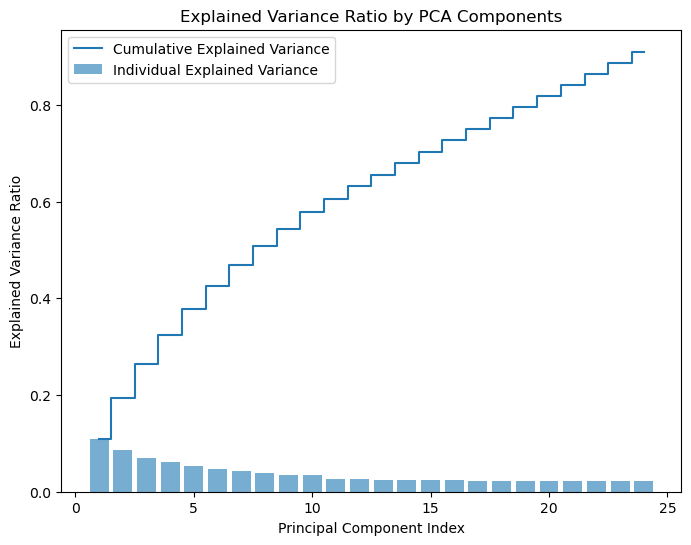

In [7]:
# Linear Regression model
# Implements requirements stated
# PROBLEM STATEMENT: Identifying and understanding the key factors that influence sleep quality.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv").iloc[:, 1:]
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df = pd.get_dummies(df, columns=['Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder'], drop_first=True)

# Define features and target
X = df.drop(columns=['Quality of Sleep'])
y = df['Quality of Sleep']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that standardizes the data, applies PCA, and then fits a linear regression model
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lin_reg', LinearRegression())
])

# Define a parameter grid to search over: Number of PCA components
param_grid = {
    'pca__n_components': np.arange(5, min(len(X.columns), 25))
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and best score (i.e., mean squared error)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (MSE): ", -grid_search.best_score_)

# Use the best model to make predictions on the test set
y_pred = grid_search.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
print("Test set MSE: ", mse_test)

# Access the PCA component from the best estimator of the grid search
best_pca = grid_search.best_estimator_.named_steps['pca']
explained_variance_ratio = best_pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance
n_components = len(explained_variance_ratio)
plt.figure(figsize=(8, 6))
plt.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.6, label='Individual Explained Variance')
plt.step(range(1, n_components + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.title('Explained Variance Ratio by PCA Components')
plt.show()

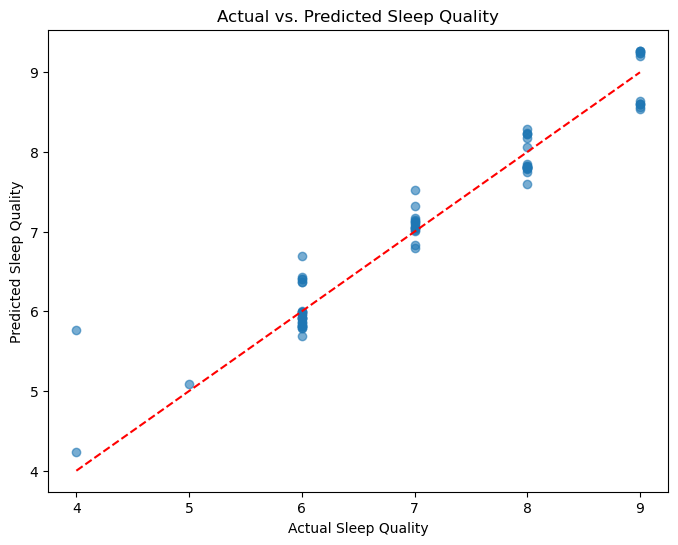

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.title('Actual vs. Predicted Sleep Quality')
plt.xlabel('Actual Sleep Quality')
plt.ylabel('Predicted Sleep Quality')
plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.4s finished


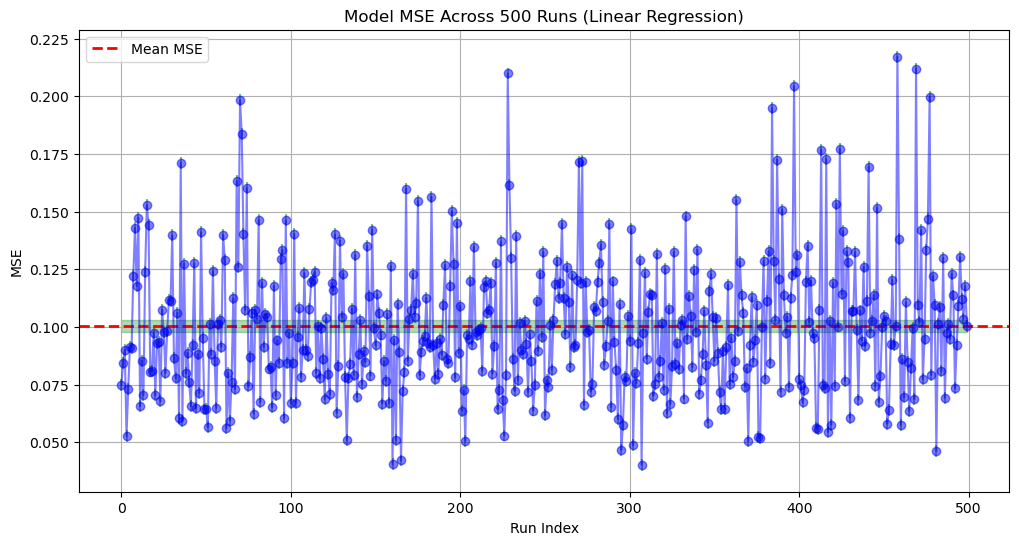

Mean MSE: 0.10018992004662565


In [9]:
# Uses the pca components from previous cell for best components
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

best_n_components = grid_search.best_params_['pca__n_components']

def train_and_evaluate_model(seed, n_components):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # Standardize the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Apply PCA on the scaled training data
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    # Transform the test data
    X_test_scaled = scaler.transform(X_test)
    X_test_pca = pca.transform(X_test_scaled)

    # Initialize and train the model on PCA data
    model = LinearRegression()
    model.fit(X_train_pca, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pca)

    # Calculate MSE on the PCA-transformed test set
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Runs
n_runs = 500 
results = Parallel(n_jobs=-1, verbose=1)(
    delayed(train_and_evaluate_model)(seed, best_n_components) for seed in range(n_runs)
)

# Convert results to array
results_array = np.array(results)

# Calculate mean MSE and standard deviation
mean_mse = np.mean(results_array)
std_deviation = np.std(results_array)
margin_of_error = 1.96 * (std_deviation / np.sqrt(n_runs))

indices = np.arange(n_runs)

# Plot the mean MSE with confidence interval using error bars
plt.figure(figsize=(12, 6))
plt.errorbar(indices, results_array, yerr=margin_of_error, fmt='o', linestyle='-', color='b', ecolor='g', alpha=0.5)
plt.fill_between(indices, mean_mse - margin_of_error, mean_mse + margin_of_error, color='g', alpha=0.3)
plt.axhline(mean_mse, color='red', linestyle='dashed', linewidth=2, label='Mean MSE')
plt.xlabel('Run Index')
plt.ylabel('MSE')
plt.title(f'Model MSE Across {n_runs} Runs (Linear Regression)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Mean MSE: {mean_mse}")

In [10]:
# Output Accuracy, R^2
from sklearn.metrics import r2_score

# Use the best model from the grid search to make predictions on the test set
y_pred = grid_search.predict(X_test)

# Calculate the R-squared value for the test set
r2_test = r2_score(y_test, y_pred)
print("Test set R-squared: ", r2_test)


Test set R-squared:  0.932448900710167
